## Importación de las librerías 

In [1]:
import utils
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree

## Conjuntos de entrenamiento y test y CV controller

In [2]:
X_train, X_test, y_train, y_test = utils.get_train_test_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7776, 12) (1022, 12) (7776,) (1022,)


In [3]:
cv = utils.get_stratified_shuffle_cv()
print(cv)

StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8)


## Carga del mejor árbol de clasificación

Este será el árbol que se empleará para realizar el **gradient boosting**

In [4]:
decision_tree_model = pickle.load(open('/kaggle/input/decision-tree-model/decision_tree_model.sav', 'rb'))
print(decision_tree_model.criterion)
decision_tree_model

gini


DecisionTreeClassifier(max_depth=10, min_samples_leaf=45, min_samples_split=200,
                       random_state=99)

## Búsqueda del parámetro subsamples (sthocastic gradient boosting) del gradient boosting

In [19]:
param_grid = {
    'n_estimators': list(range(50,501,50)),
    'subsample': list(np.arange(0.1,1.01,0.1))
}

grid_search_cv = GridSearchCV(
    GradientBoostingClassifier(max_features='sqrt', max_depth=decision_tree_model.max_depth, min_samples_leaf=decision_tree_model.min_samples_leaf,
                               min_samples_split=decision_tree_model.min_samples_split, random_state=99),
    param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=0, n_jobs=-1
)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=GradientBoostingClassifier(max_depth=10,
                                                  max_features='sqrt',
                                                  min_samples_leaf=45,
                                                  min_samples_split=200,
                                                  random_state=99),
             n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500],
                         'subsample': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                                       0.6, 0.7000000000000001, 0.8, 0.9,
                                       1.0]},
             scoring='roc_auc')

Escogemos como max_samples 0.5, ya que apartir de alli no hay mejora significativa

<AxesSubplot:xlabel='estimators', ylabel='mean_test_score'>

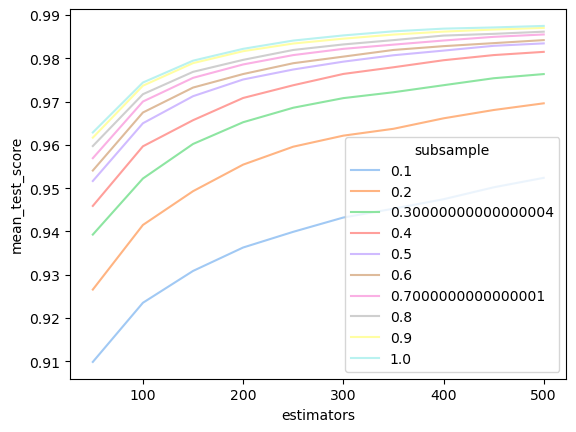

In [20]:
estimators_list = list(grid_search_cv.cv_results_['param_n_estimators'].data)
subsample_list = list(grid_search_cv.cv_results_['param_subsample'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
gradient_boosting_df = pd.DataFrame(list(zip(estimators_list, subsample_list, mean_test_score_list)), columns=['estimators', 'subsample', 'mean_test_score'])
sns.lineplot(data=gradient_boosting_df, x="estimators", y="mean_test_score", hue="subsample", legend="full", palette="pastel")

## Búsqueda del parámetro learning_rate del gradient boosting

sqrt y log2 dan 3.5 por eso dan siempre igual

In [22]:
param_grid = {
    'n_estimators': list(range(100,1001,100)),
    'learning_rate': [0.1, 0.05, 0.03, 0.01, 0.001]
}

grid_search_cv = GridSearchCV(
    GradientBoostingClassifier(max_features='sqrt', subsample=0.5, max_depth=decision_tree_model.max_depth,
                               min_samples_leaf=decision_tree_model.min_samples_leaf,
                               min_samples_split=decision_tree_model.min_samples_split, random_state=99),
    param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=0, n_jobs=-1
)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=GradientBoostingClassifier(max_depth=10,
                                                  max_features='sqrt',
                                                  min_samples_leaf=45,
                                                  min_samples_split=200,
                                                  random_state=99,
                                                  subsample=0.5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.03, 0.01, 0.001],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]},
             scoring='roc_auc')

Seleccionamos el valor del **learning rate** como 0.1

<AxesSubplot:xlabel='estimators', ylabel='mean_test_score'>

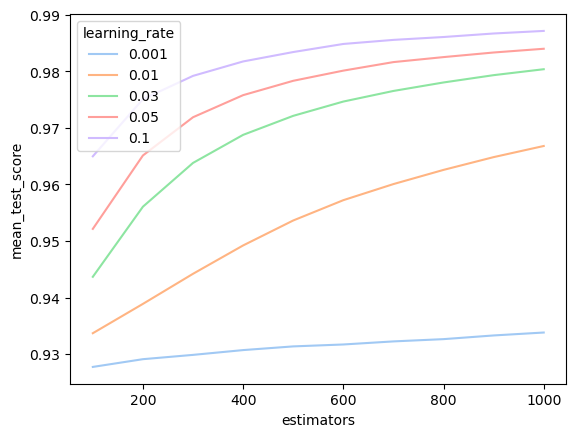

In [25]:
estimators_list = list(grid_search_cv.cv_results_['param_n_estimators'].data)
learning_rate_list = list(grid_search_cv.cv_results_['param_learning_rate'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
gradient_boosting_df = pd.DataFrame(list(zip(estimators_list, learning_rate_list, mean_test_score_list)), columns=['estimators', 'learning_rate', 'mean_test_score'])
sns.lineplot(data=gradient_boosting_df, x="estimators", y="mean_test_score", hue="learning_rate", legend="full", palette="pastel")

## Búsqueda del parámetro n_estimators del gradient boosting

Llegaremos hasta 1000 ya que a partir de alli no hay mejora significativa

In [26]:
param_grid = {
    'n_estimators': list(range(10,1001,20)),
}

grid_search_cv = GridSearchCV(
    GradientBoostingClassifier(max_features='sqrt', learning_rate=0.1, subsample=0.5, max_depth=decision_tree_model.max_depth,
                               min_samples_leaf=decision_tree_model.min_samples_leaf,
                               min_samples_split=decision_tree_model.min_samples_split, random_state=99),
    param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=0, n_jobs=-1
)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=GradientBoostingClassifier(max_depth=10,
                                                  max_features='sqrt',
                                                  min_samples_leaf=45,
                                                  min_samples_split=200,
                                                  random_state=99,
                                                  subsample=0.5),
             n_jobs=-1,
             param_grid={'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150,
                                          170, 190, 210, 230, 250, 270, 290,
                                          310, 330, 350, 370, 390, 410, 430,
                                          450, 470, 490, 510, 530, 550, 570,
                                          590, ...]},
             scoring='roc_auc')

Decidimos que el número de árboles a usar será: **20** (por prueba y error básicamente) ya que la mejora desde allí es insignificativa, además es un modelo menos sobrejustado

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  


<AxesSubplot:xlabel='estimators', ylabel='mean_test_score'>

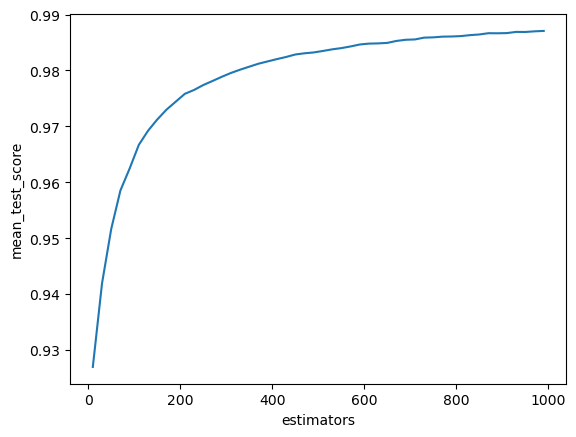

In [27]:
estimators_list = list(grid_search_cv.cv_results_['param_n_estimators'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
gradient_boosting_df = pd.DataFrame(list(zip(estimators_list, mean_test_score_list)), columns=['estimators', 'mean_test_score'])
gradient_boosting_df['mean_test_score_shift'] = gradient_boosting_df['mean_test_score'].shift().fillna(0)
gradient_boosting_df['diff'] = (gradient_boosting_df['mean_test_score'] - gradient_boosting_df['mean_test_score_shift'])
sns.lineplot(data=gradient_boosting_df, x="estimators", y="mean_test_score", legend="full", palette="pastel")

In [28]:
gradient_boosting_df

,estimators,mean_test_score,mean_test_score_shift,diff
0,10,0.926957,0.000000,0.926957
1,30,0.941908,0.926957,0.014951
2,50,0.951645,0.941908,0.009738
3,70,0.958538,0.951645,0.006893
4,90,0.962454,0.958538,0.003915
5,110,0.966696,0.962454,0.004242
6,130,0.969217,0.966696,0.002521
7,150,0.971227,0.969217,0.002011
8,170,0.972985,0.971227,0.001757
9,190,0.974406,0.972985,0.001422


**Modelo de gradient boosting**

Confusion matrix, without normalization
[[756 216]
 [ 15  35]]


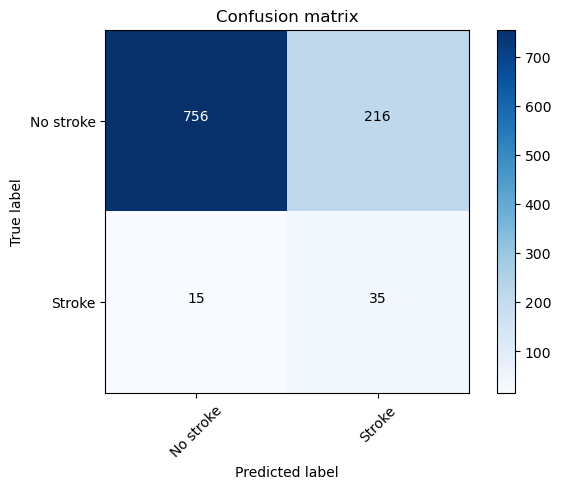

In [51]:
gradient_boosting_model = GradientBoostingClassifier(
    max_features='sqrt', learning_rate=0.1, subsample=0.5, max_depth=decision_tree_model.max_depth,
    min_samples_leaf=decision_tree_model.min_samples_leaf, n_estimators=20,
    min_samples_split=decision_tree_model.min_samples_split, random_state=99)

gradient_boosting_model.fit(X_train, y_train)
y_pred = gradient_boosting_model.predict(X_test)

cm = utils.get_confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm=cm, classes=['No stroke', 'Stroke'])

              precision    recall  f1-score   support

           0       0.98      0.78      0.87       972
           1       0.14      0.70      0.23        50

    accuracy                           0.77      1022
   macro avg       0.56      0.74      0.55      1022
weighted avg       0.94      0.77      0.84      1022



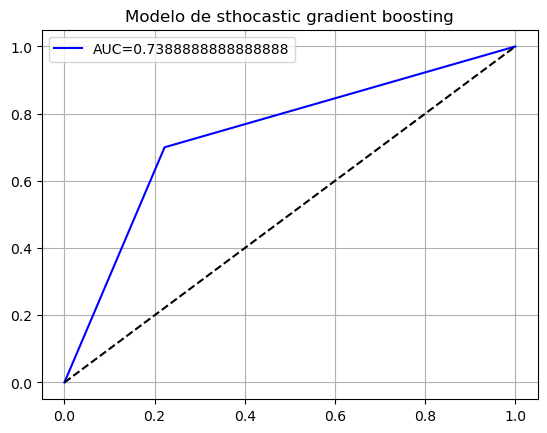

In [52]:
utils.print_metrics(y_test, y_pred, "Modelo de sthocastic gradient boosting")

## Importancia de las variables

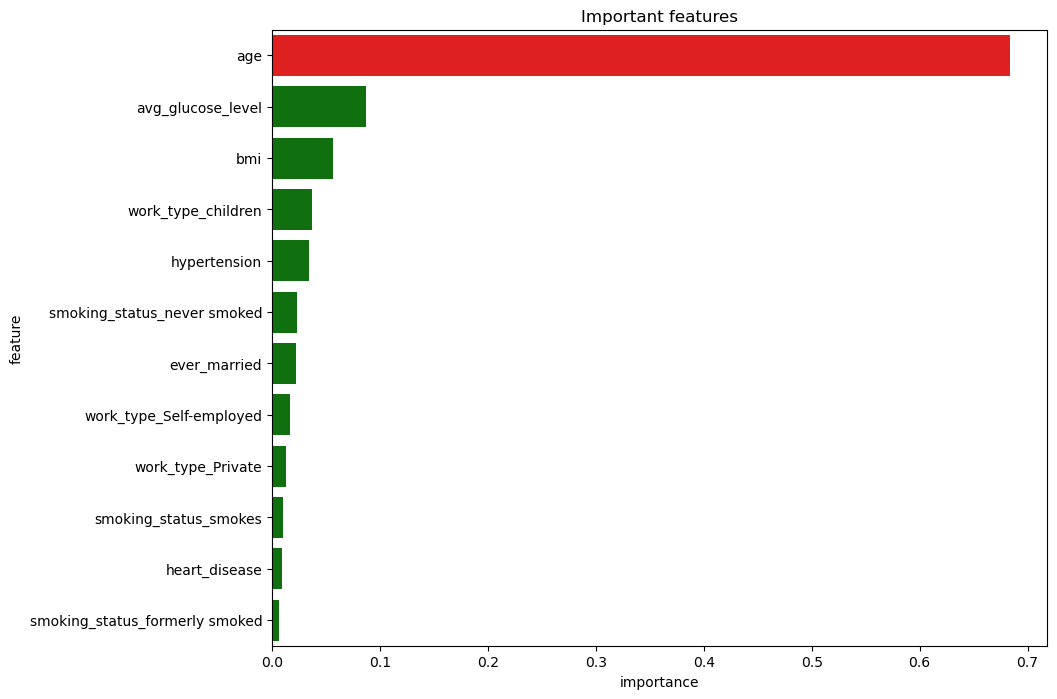

In [53]:
utils.plot_tree_feature_importance(gradient_boosting_model.feature_names_in_, gradient_boosting_model.feature_importances_)

**Guardamos el modelo para la comparativa final**

In [54]:
pickle.dump(gradient_boosting_model, open("gradient_boosting_model.sav", 'wb'))